In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('filenames_011625.txt', header=None)
df.columns = ['filepath']
df['pi'] = df['filepath'].str.extract(r'pi(\d+)')
df['datetime'] = pd.to_datetime(df['filepath'].str.extract(r'_(\d{8}_\d{6})')[0], format='%Y%m%d_%H%M%S')
df['datetime'] = pd.to_datetime(df['datetime'])
df['pi'] = df['pi'].astype(int)
df = df.drop(columns='filepath')
df = df[df['datetime'] >= '2024-07-11']

In [3]:
trtmnt = pd.read_csv('csvs/bee_cam_treatments.csv')
trtmnt.columns = ['date', 'pi', 'color']
trtmnt['date'] = pd.to_datetime(trtmnt['date'], format="%m/%d")
trtmnt['date'] = trtmnt['date'].apply(lambda x: x.replace(year=2024, hour=0, minute=0))
trtmnt['date'] = trtmnt['date'].replace('2024-07-23', '2024-07-24')
trtmnt.loc[trtmnt['date'] == '2024-08-15', 'date'] = pd.to_datetime('2024-08-15 17:00')
trtmnt = trtmnt.sort_values(by=['pi', 'date'])
trtmnt['end_date'] = trtmnt.groupby('pi')['date'].shift(-1)
trtmnt['end_date'].fillna(pd.Timestamp('2024-09-10 00:00'), inplace=True)
trtmnt['interval'] = trtmnt.apply(lambda row: pd.Interval(left=row['date'], right=row['end_date'], closed='left'), axis=1)

In [4]:
stim_intervals = trtmnt[['pi', 'color', 'interval']].reset_index(drop=True)
stim_intervals.to_csv('csvs/stimulus_intervals.csv', index=False)

In [5]:
df['color'] = None
for _, row in stim_intervals.iterrows():
    mask = (df['pi'] == row['pi']) & (df['datetime'].between(row['interval'].left, row['interval'].right))
    df.loc[mask, 'color'] = row['color']

In [6]:
df = df.sort_values(['pi', 'datetime'])
df['time_diff'] = df.groupby('pi')['datetime'].diff()
df['session_start'] = df['time_diff'].dt.total_seconds().fillna(0) >= 15
df['session_id'] = df.groupby('pi')['session_start'].cumsum()
result_df = df.groupby(['pi', 'session_id']).agg(
    start_time=('datetime', 'min'),
    end_time=('datetime', 'max'),
    most_frequent_color=('color', lambda x: x.mode()[0] if not x.mode().empty else None)
).reset_index()
result_df['interval'] = result_df.apply(lambda row: pd.Interval(left=row['start_time'], right=row['end_time'], closed='both'), axis=1)
result_df = result_df[['pi', 'interval', 'most_frequent_color']]
result_df.columns = ['pi', 'interval', 'color']

In [7]:
result_df.to_csv('csvs/camera_intervals.csv', index=False)

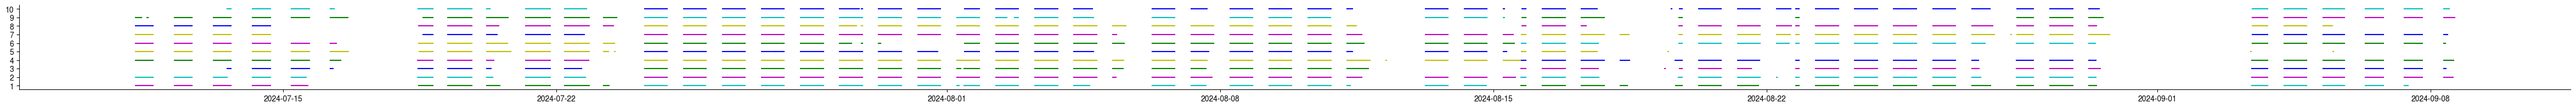

In [8]:
color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y'
}

fig, ax = plt.subplots(figsize=(60, 2))
for i, row in result_df.iterrows():
    start = row['interval'].left
    end = row['interval'].right
    color = color_map[row['color']]
    pi = row['pi']
    ax.plot([start, end], [pi, pi], color=color)

ax.set_yticks(df['pi'].unique())
ax.set_yticklabels(df['pi'].unique())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()